# T81-558: Applications of Deep Neural Networks
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), School of Engineering and Applied Science, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

**Module 7 Assignment: Computer Vision Neural Network**

**Student Name: Jie Miao**

# Assignment Instructions

For this assignment you will use the MINST dataset to train and predict several handwritten digits.  For the creation and training of the neural network, you can [copy the code](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class7_cnn.ipynb) from class for much of this assignment.  Use the provided code to download the training and testing data for the handwritten digits and predict the following **testing set** digits (10,20,30,40,50):

* Index 10: which is the digit '0'
* Index 20: which is the digit '9'
* Index 30: which is the digit '3'
* Index 40: which is the digit '1'
* Index 50: which is the digit '6'

You will predict these 5 digits. You will submit these perdictions to the submit function. See [Assignment #1]() for details on how to submit an assignment or check that one was submitted. Your submitted dataframe should have 5 data rows (one offor each of the indexes).  You should have the columns **id**, **pred**, and **y**.  The column **id** specifies which index the prediction is for (10, 20, 30, 40, 50).  The column **pred** is your prediction (0-9).  The column **y** is the actual digit for that index (0-9).  Your sumission will only have 5 rows and might look something like the following:

id | pred | y
---|---|---
10 | 0 | 0
20 | 9 | 9
30 | 3 | 3
40 | 1 | 1
50 | 6 | 6

**Important suggestion** You will likely see training times upwards of an hour.  Place your training code in a different cell than your code to get predictions and submit.  Otherwise you will have to retrain for every test of your network, and that will take forever!  You can also save your trained neural network to a binary file and reload it.

# Helpful Functions

You will see these at the top of every module and assignment.  These are simply a set of reusable functions that we will make use of.  Each of them will be explained as the semester progresses.  They are explained in greater detail as the course progresses.  Class 4 contains a complete overview of these functions.

In [1]:
import base64
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from sklearn import preprocessing


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = f"{name}-{tv}"
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(
        target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    # Regression
    return df[result].values.astype(np.float32), df[[target]].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"


# Regression chart.
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean())
                          >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
        * (normalized_high - normalized_low) + normalized_low


# This function submits an assignment.  You can submit an assignment as much as you like, only the final
# submission counts.  The paramaters are as follows:
# data - Pandas dataframe output.
# key - Your student key that was emailed to you.
# no - The assignment class number, should be 1 through 1.
# source_file - The full path to your Python or IPYNB file.  This must have "_class1" as part of its name.  
# .             The number must match your assignment number.  For example "_class2" for class assignment #2.
def submit(data,key,no,source_file=None):
    if source_file is None and '__file__' not in globals(): raise Exception('Must specify a filename when a Jupyter notebook.')
    if source_file is None: source_file = __file__
    suffix = '_class{}'.format(no)
    if suffix not in source_file: raise Exception('{} must be part of the filename.'.format(suffix))
    with open(source_file, "rb") as image_file:
        encoded_python = base64.b64encode(image_file.read()).decode('ascii')
    ext = os.path.splitext(source_file)[-1].lower()
    if ext not in ['.ipynb','.py']: raise Exception("Source file is {} must be .py or .ipynb".format(ext))
    r = requests.post("https://api.heatonresearch.com/assignment-submit",
        headers={'x-api-key':key}, json={'csv':base64.b64encode(data.to_csv(index=False).encode('ascii')).decode("ascii"),
        'assignment': no, 'ext':ext, 'py':encoded_python})
    if r.status_code == 200:
        print("Success: {}".format(r.text))
    else: print("Failure: {}".format(r.text))

# Assignment #7 Sample Code

The following code provides a starting point for this assignment.

In [58]:
import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.datasets import mnist
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import tensorflow as tf
import time

# This is your student key that I emailed to you at the beginnning of the semester.
key = "qqeAIdN7kdaHWUmLYRyM5aHJxb8Yt5Ssw0qi11wb"   # This is an example key and will not work.

# You must also identify your source file.  (modify for your local setup)
# file='/resources/t81_558_deep_learning/assignment_yourname_class1.ipynb'  # IBM Data Science Workbench
# file='C:\\Users\\jeffh\\projects\\t81_558_deep_learning\\t81_558_class1_intro_python.ipynb'  # Windows
file='/Users/jie/Desktop/t81_558_deep_learning-master/assignments/assignment_JieMiao_class7.ipynb' # Mac/Linux

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Add assignment code here
batch_size = 128
num_classes = 10
epochs = 12
# input image dimensions
img_rows, img_cols = 28, 28
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print("Training samples: {}".format(x_train.shape[0]))
print("Test samples: {}".format(x_test.shape[0]))
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
start_time = time.time()

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

x_train shape: (60000, 28, 28, 1)
Training samples: 60000
Test samples: 10000
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
 - 81s - loss: 0.2620 - acc: 0.9195 - val_loss: 0.0601 - val_acc: 0.9820
Epoch 2/12
 - 80s - loss: 0.0864 - acc: 0.9744 - val_loss: 0.0420 - val_acc: 0.9860
Epoch 3/12
 - 77s - loss: 0.0634 - acc: 0.9809 - val_loss: 0.0360 - val_acc: 0.9887
Epoch 4/12
 - 77s - loss: 0.0521 - acc: 0.9848 - val_loss: 0.0327 - val_acc: 0.9900
Epoch 5/12
 - 77s - loss: 0.0456 - acc: 0.9861 - val_loss: 0.0293 - val_acc: 0.9900
Epoch 6/12
 - 77s - loss: 0.0390 - acc: 0.9882 - val_loss: 0.0274 - val_acc: 0.9913
Epoch 7/12
 - 77s - loss: 0.0353 - acc: 0.9895 - val_loss: 0.0282 - val_acc: 0.9908
Epoch 8/12
 - 77s - loss: 0.0336 - acc: 0.9899 - val_loss: 0.0259 - val_acc: 0.9918
Epoch 9/12
 - 77s - loss: 0.0310 - acc: 0.9901 - val_loss: 0.0262 - val_acc: 0.9913
Epoch 10/12
 - 77s - loss: 0.0293 - acc: 0.9909 - val_loss: 0.0291 - val_acc: 0.9899
Epoch 11/12
 - 77s - loss: 0.02

In [60]:
ids = [10,20,30,40,50]

pred = model.predict(x_test)
pred2 = np.argmax(pred,axis=1)
y_comp = np.argmax(y_test,axis=1)

df_submit = pd.DataFrame({'id':ids,'pred':pred2[ids],'y':y_comp[ids]})
submit(source_file=file,data=df_submit,key=key,no=7)

Success: Submitted Assignment #7 for j.miao:
You have submitted this assignment 2 times. (this is fine)
No warnings on your data. You will probably do well, but no guarantee. :-)



Image (#9): Which is digit '[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]'


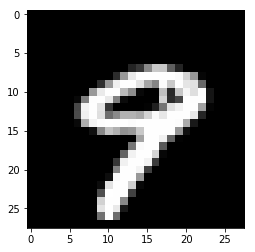

In [54]:
# Display as image
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
digit = 9 # Change to choose new digit
a = x_test[digit].reshape(28,28)
plt.imshow(a, cmap='gray', interpolation='nearest')
print("Image (#{}): Which is digit '{}'".format(digit,y_train[digit]))
